In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob as gb
import tqdm
import tensorflow as tf
from tensorflow.keras import backend as K

In [2]:
postion=pd.read_csv('train_labels_.csv')

In [3]:
postion.head()

filename  width  height    class  xmin  ymin  xmax  ymax
0  raccoon-17.jpg    259     194  raccoon    95    60   167   118
1  raccoon-11.jpg    660     432  raccoon     3     1   461   431
2  raccoon-63.jpg    600     400  raccoon    74   107   280   290
3  raccoon-63.jpg    600     400  raccoon   227    93   403   298
4  raccoon-60.jpg    273     185  raccoon    58    33   197   127

In [4]:
postion.shape

(173, 8)

In [7]:
postion['filename']

0       raccoon-17.jpg
1       raccoon-11.jpg
2       raccoon-63.jpg
3       raccoon-63.jpg
4       raccoon-60.jpg
            ...       
168    raccoon-137.jpg
169    raccoon-171.jpg
170    raccoon-190.jpg
171     raccoon-22.jpg
172    raccoon-152.jpg
Name: filename, Length: 173, dtype: object

In [ ]:
#loading data and resize it and collect it in one folder

trainpath = 'C:/Users/Diti/Desktop/project 11/Racoon Images/images/'
new_size=128    
X_train = []
y_train = []

for path in tqdm.tqdm(postion['filename'].values[:161]):
    orignal_image = cv2.imread(trainpath+path)
    print(trainpath+path)
    image = cv2.cvtColor(orignal_image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image , (new_size,new_size))
    X_train.append(resized_image)
print('image reading ...finished')
print('--------------------------------------------------')        


In [12]:
X_train=np.array(X_train)

In [13]:
X_train = X_train / 255.0

In [14]:
X_train.shape

(161, 128, 128, 3)

In [15]:
img=plt.imread('Racoon Images/images/raccoon-17.jpg')

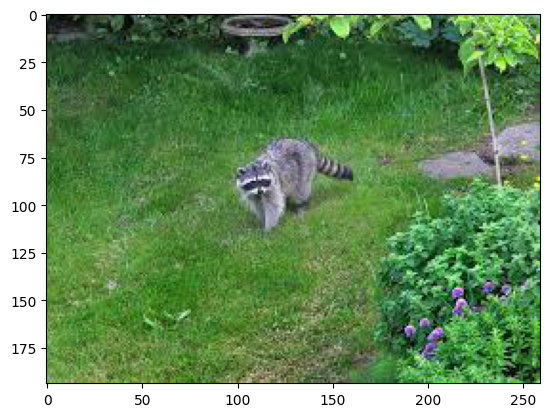

In [16]:
plt.imshow(img)

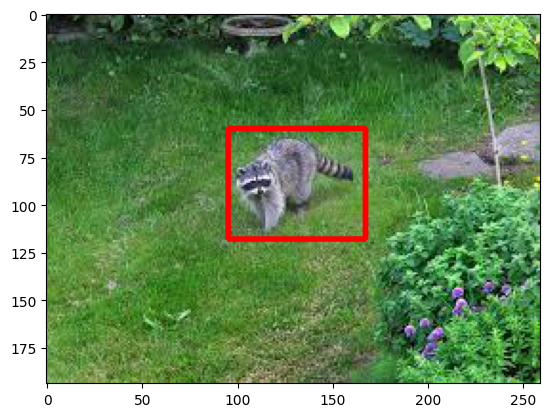

In [17]:
index = 0
img=cv2.rectangle(img,
                  (postion['xmin'][index],postion['ymin'][index]),
                  (postion['xmax'][index],postion['ymax'][index]), 
                  (255,0,0),2)
plt.imshow(img)   

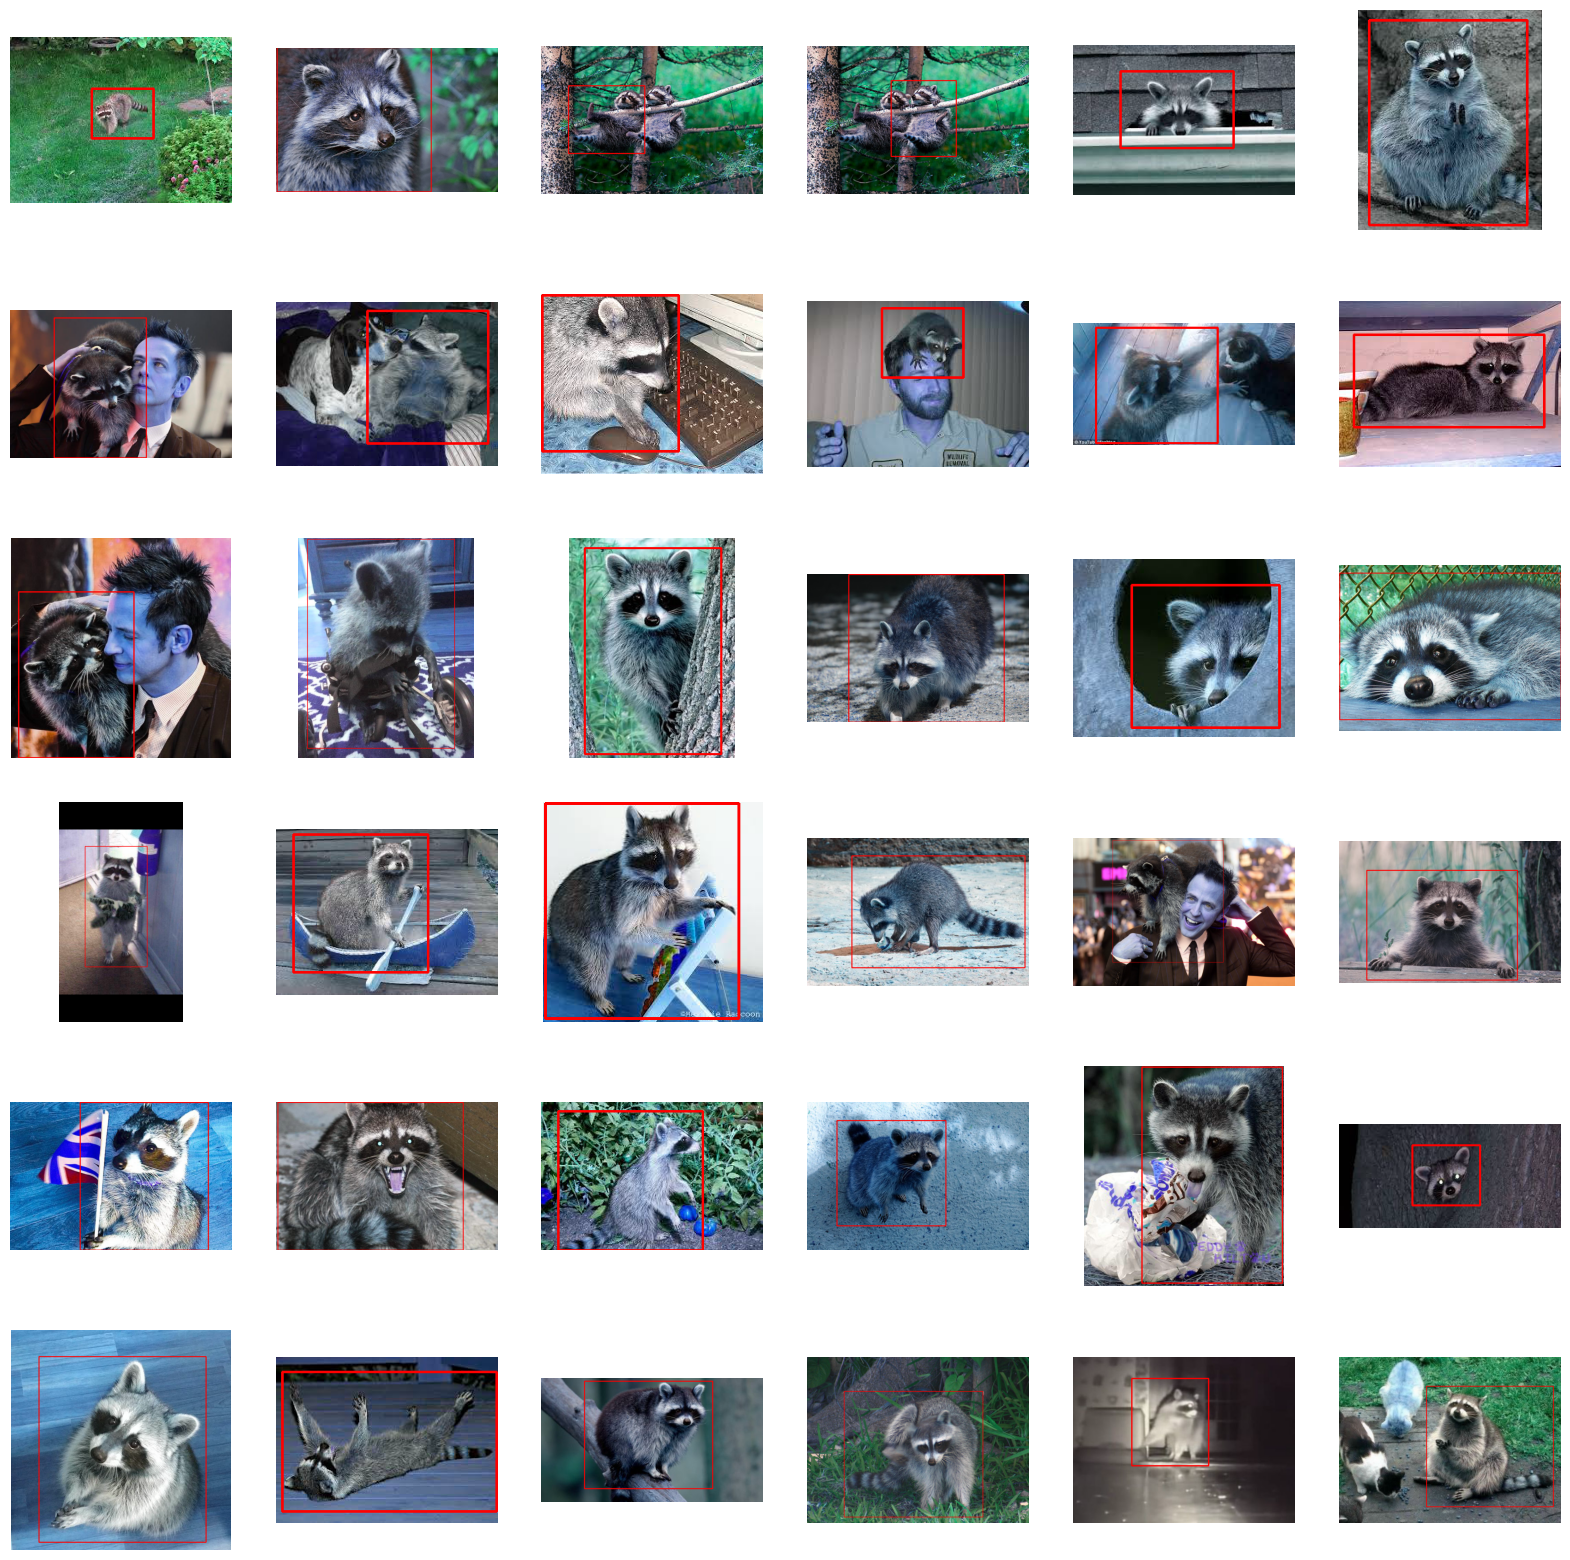

In [18]:
#showing training images with labels
plt.figure(figsize=(20,20))
for n , i in enumerate(range(36)) : 
    plt.subplot(6,6,n+1)
    img = cv2.imread(trainpath+str(postion.iloc[i,0]))
    img=cv2.rectangle(img,(postion['xmin'][i],postion['ymin'][i]), (postion['xmax'][i],postion['ymax'][i]) , (255,0,0),2)
    plt.imshow(img)   
    plt.axis('off')
    


In [19]:
#loading data and resize it and collect it in one folder

testpath = 'C:/Users/Diti/Desktop/project 11/Racoon Images/images/'
new_size=128    
X_test = []
y_test = []

for path in tqdm.tqdm(postion['filename'].values[161:]): 
    orignal_image = cv2.imread(testpath+path)
    image = cv2.cvtColor(orignal_image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image , (new_size,new_size))
    X_test.append(resized_image)
    
X_test = np.array(X_test)
X_test = X_test / 255.0
print('image reading ...finished')

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 65.97it/s]

image reading ...finished


In [20]:
postion=postion[["width","height","xmin","ymin","xmax","ymax"]]

postion["xmin"] = postion["xmin"] *new_size/postion["width"]
postion["xmax"] = postion["xmax"]*new_size /postion["width"]
postion["ymin"] = postion["ymin"] *new_size/postion["height"]
postion["ymax"] = postion["ymax"] *new_size/postion["height"]

In [21]:
#postion=postion.astype('int32')
postion.drop(['width','height'],axis=1,inplace=True)
postion.head()

xmin       ymin       xmax        ymax
0  46.949807  39.587629  82.532819   77.855670
1   0.581818   0.296296  89.406061  127.703704
2  15.786667  34.240000  59.733333   92.800000
3  48.426667  29.760000  85.973333   95.360000
4  27.194139  22.832432  92.366300   87.870270

In [22]:
y_train=postion.iloc[:161,:]
y_test=postion.iloc[161:,:]

In [23]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

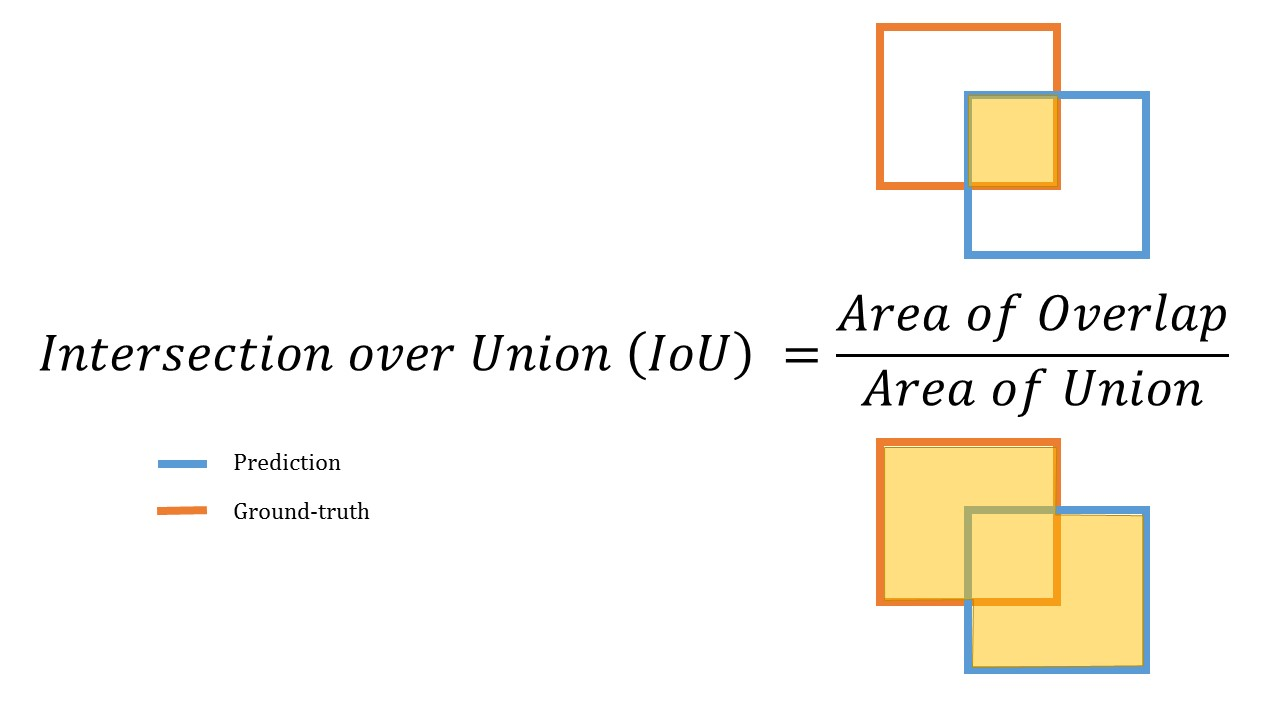

In [24]:
from tensorflow.keras.backend import epsilon
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

In [25]:
#callbacks
EarlyStop=EarlyStopping(patience=5,monitor='val_iou',restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_iou',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_iou',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

#optimizer
optimizer_adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)

In [26]:
model=Sequential([
                    Conv2D(64,3,activation='relu',kernel_initializer='he_normal',input_shape=(new_size,new_size,3),kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    BatchNormalization(),
                    MaxPooling2D(3),
    
                    Conv2D(128,3,activation='relu',kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    BatchNormalization(),
                    MaxPooling2D(3),
    
                    Conv2D(256,3,activation='relu',kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    BatchNormalization(),
                    MaxPooling2D(3),
    
    
                    Flatten(),
                    Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    Dense(4,activation='relu',kernel_initializer='glorot_normal')
                  
])



In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 40, 40, 128)      512       
 hNormalization)                                                 
                                                        

In [ ]:
model.compile(optimizer=optimizer_adam, loss='mse', metrics=[IoU])

history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=4,
                  steps_per_epoch=len(X_train)//4,
                  callbacks=callback, verbose=1)

Epoch 1/200
40/40 [==============================] - 16s 313ms/step - loss: 1288.1979 - IoU: 0.3701 - val_loss: 3362.0813 - val_IoU: 0.0492 - lr: 0.0010
Epoch 2/200
40/40 [==============================] - 14s 360ms/step - loss: 611.0461 - IoU: 0.4397 - val_loss: 2350.4504 - val_IoU: 0.0771 - lr: 0.0010
Epoch 3/200
40/40 [==============================] - 15s 363ms/step - loss: 569.7092 - IoU: 0.4668 - val_loss: 2332.7981 - val_IoU: 0.0805 - lr: 0.0010
Epoch 4/200
40/40 [==============================] - 12s 302ms/step - loss: 515.0812 - IoU: 0.4771 - val_loss: 1979.7656 - val_IoU: 0.1341 - lr: 0.0010
Epoch 5/200
40/40 [==============================] - 11s 286ms/step - loss: 503.5495 - IoU: 0.4680 - val_loss: 1526.7201 - val_IoU: 0.1834 - lr: 0.0010
Epoch 6/200
40/40 [==============================] - 14s 342ms/step - loss: 544.5637 - IoU: 0.4887 - val_loss: 846.8122 - val_IoU: 0.2994 - lr: 0.0010
Epoch 7/200
40/40 [==============================] - 14s 361ms/step - loss: 526.7026 - I

40/40 [==============================] - 13s 325ms/step - loss: 327.8510 - IoU: 0.5729 - val_loss: 511.8528 - val_IoU: 0.4768 - lr: 0.0010
Epoch 15/200
40/40 [==============================] - 13s 317ms/step - loss: 310.2829 - IoU: 0.5784 - val_loss: 650.5364 - val_IoU: 0.4958 - lr: 0.0010
Epoch 16/200
40/40 [==============================] - 13s 335ms/step - loss: 327.1159 - IoU: 0.5660 - val_loss: 533.4169 - val_IoU: 0.4733 - lr: 0.0010
Epoch 17/200
40/40 [==============================] - 12s 314ms/step - loss: 254.9958 - IoU: 0.5904 - val_loss: 659.0527 - val_IoU: 0.4738 - lr: 0.0010
Epoch 18/200
40/40 [==============================] - 11s 285ms/step - loss: 313.2635 - IoU: 0.5830 - val_loss: 517.8874 - val_IoU: 0.5095 - lr: 0.0010
Epoch 19/200
40/40 [==============================] - 12s 309ms/step - loss: 200.0784 - IoU: 0.6420 - val_loss: 455.6828 - val_IoU: 0.4976 - lr: 0.0010
Epoch 20/200
40/40 [==============================] - 11s 269ms/step - loss: 255.2120 - IoU: 0.6017 -

40/40 [==============================] - 11s 281ms/step - loss: 233.2918 - IoU: 0.6296 - val_loss: 496.6956 - val_IoU: 0.5075 - lr: 0.0010
Epoch 29/200
40/40 [==============================] - 11s 277ms/step - loss: 231.8825 - IoU: 0.6417 - val_loss: 458.3960 - val_IoU: 0.4947 - lr: 0.0010
Epoch 30/200
40/40 [==============================] - 11s 263ms/step - loss: 241.5152 - IoU: 0.6375 - val_loss: 500.4938 - val_IoU: 0.5103 - lr: 0.0010
Epoch 31/200
40/40 [==============================] - 10s 259ms/step - loss: 247.7719 - IoU: 0.6244 - val_loss: 507.8574 - val_IoU: 0.4362 - lr: 0.0010
Epoch 32/200
40/40 [==============================] - 11s 274ms/step - loss: 234.7804 - IoU: 0.6380 - val_loss: 476.4836 - val_IoU: 0.5362 - lr: 0.0010
Epoch 33/200
40/40 [==============================] - 11s 274ms/step - loss: 230.0146 - IoU: 0.6417 - val_loss: 438.6185 - val_IoU: 0.5013 - lr: 0.0010
Epoch 34/200
40/40 [==============================] - 11s 264ms/step - loss: 264.3277 - IoU: 0.6213 -

Epoch 42/200
40/40 [==============================] - 11s 283ms/step - loss: 212.6037 - IoU: 0.6632 - val_loss: 428.4952 - val_IoU: 0.4620 - lr: 0.0010
Epoch 43/200
40/40 [==============================] - 10s 267ms/step - loss: 241.5811 - IoU: 0.6212 - val_loss: 543.6938 - val_IoU: 0.4944 - lr: 0.0010
Epoch 44/200
40/40 [==============================] - 11s 265ms/step - loss: 217.4140 - IoU: 0.6472 - val_loss: 439.5897 - val_IoU: 0.5148 - lr: 0.0010
Epoch 45/200
40/40 [==============================] - 11s 270ms/step - loss: 247.4316 - IoU: 0.6351 - val_loss: 417.0205 - val_IoU: 0.5381 - lr: 0.0010
Epoch 46/200
40/40 [==============================] - 11s 278ms/step - loss: 212.6061 - IoU: 0.6381 - val_loss: 498.6715 - val_IoU: 0.5127 - lr: 0.0010
Epoch 47/200
40/40 [==============================] - 11s 272ms/step - loss: 248.3414 - IoU: 0.6280 - val_loss: 466.7144 - val_IoU: 0.4666 - lr: 0.0010
Epoch 48/200
40/40 [==============================] - 11s 267ms/step - loss: 205.8375 - 

40/40 [==============================] - 16s 414ms/step - loss: 221.4383 - IoU: 0.6540 - val_loss: 410.7494 - val_IoU: 0.5132 - lr: 0.0010
Epoch 56/200
40/40 [==============================] - 19s 488ms/step - loss: 201.5583 - IoU: 0.6595 - val_loss: 363.1474 - val_IoU: 0.5284 - lr: 0.0010
Epoch 57/200
40/40 [==============================] - 18s 440ms/step - loss: 236.7514 - IoU: 0.6435 - val_loss: 499.0865 - val_IoU: 0.4554 - lr: 0.0010
Epoch 58/200
40/40 [==============================] - 18s 458ms/step - loss: 215.9149 - IoU: 0.6332 - val_loss: 419.9288 - val_IoU: 0.4806 - lr: 0.0010
Epoch 59/200
40/40 [==============================] - 17s 414ms/step - loss: 227.5652 - IoU: 0.6423 - val_loss: 426.4790 - val_IoU: 0.5078 - lr: 0.0010
Epoch 60/200
40/40 [==============================] - 18s 454ms/step - loss: 204.1524 - IoU: 0.6677 - val_loss: 375.9259 - val_IoU: 0.5150 - lr: 0.0010
Epoch 61/200
40/40 [==============================] - 16s 410ms/step - loss: 250.0836 - IoU: 0.6417 -

40/40 [==============================] - 15s 385ms/step - loss: 232.1801 - IoU: 0.6335 - val_loss: 384.4062 - val_IoU: 0.5358 - lr: 0.0010
Epoch 70/200
40/40 [==============================] - 14s 355ms/step - loss: 228.9352 - IoU: 0.6430 - val_loss: 383.5418 - val_IoU: 0.5629 - lr: 0.0010
Epoch 71/200
40/40 [==============================] - 14s 350ms/step - loss: 196.0853 - IoU: 0.6697 - val_loss: 382.5111 - val_IoU: 0.5527 - lr: 0.0010
Epoch 72/200
35/40 [=========================>....] - ETA: 1s - loss: 233.4709 - IoU: 0.6549

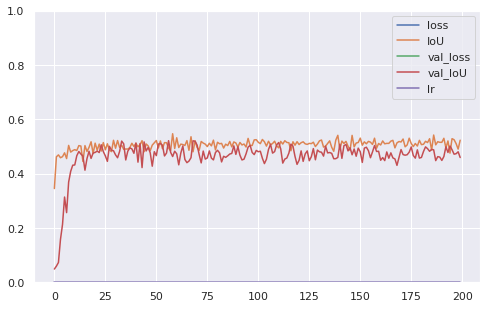

In [23]:
#plotting training values
import seaborn as sns
sns.set()


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

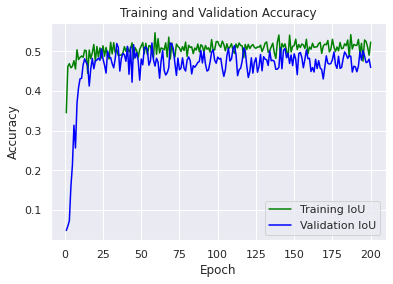

In [24]:

IoU = history.history['IoU']
val_IoU = history.history['val_IoU']
epochs = range(1, len(IoU) + 1)

#accuracy plot
plt.plot(epochs, IoU, color='green', label='Training IoU')
plt.plot(epochs, val_IoU, color='blue', label='Validation IoU')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [25]:
img=plt.imread('Racoon Images/images/raccoon-2.jpg')

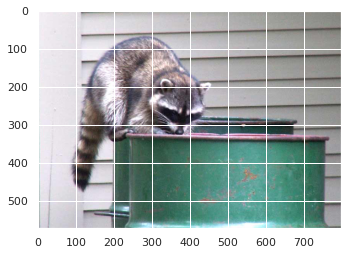

In [26]:
plt.imshow(img)

In [27]:
image_height, image_width, _ = img.shape
image = cv2.resize(img,(new_size,new_size))
image = image / 255.0

In [28]:
image.shape

(128, 128, 3)

In [29]:
image=np.expand_dims(image,axis=0)

In [30]:
region = model.predict(image)[0]

In [31]:
region

array([  0.     ,   0.     ,  70.83912, 107.37472], dtype=float32)

In [32]:
x0 = int(region[0] * image_width / new_size) 
y0 = int(region[1] * image_height / new_size)
x1 = int((region[2]) * image_width / new_size)
y1 = int((region[3]) * image_height / new_size)

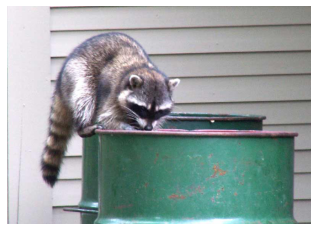

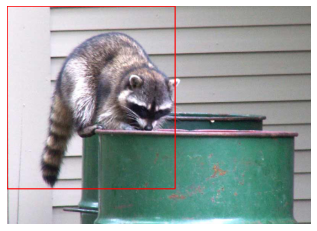

In [33]:
# Display the image
img=plt.imread('Racoon Images/images/raccoon-2.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()
# Create a Rectangle patch
cv2.rectangle(img,(x0, y0), ((x1 - x0) , (y1 - y0)) , (255,0,0),2)

# Add the patch to the Axes
plt.imshow(img)
plt.axis('off')
plt.show()

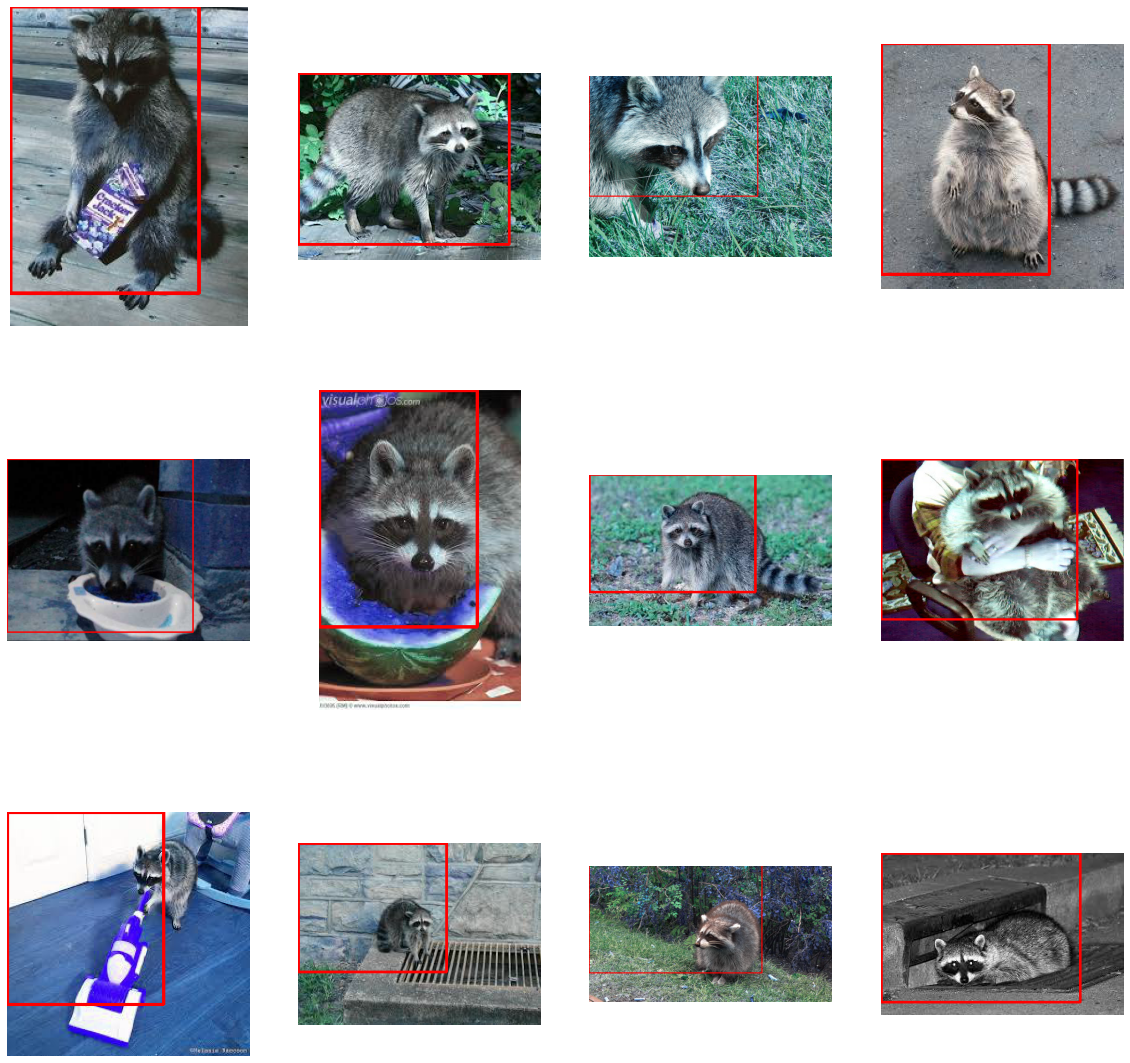

In [34]:
#showing training images with labels
df=pd.read_csv('train_labels_.csv')[161:]
plt.figure(figsize=(20,20))
for n , i in enumerate(range(12)) : 
    plt.subplot(3,4,n+1)
    
    img = cv2.imread(trainpath+str(df.iloc[i,0]))
    org_img=img.copy()
    
    image_height, image_width, _ = img.shape
    
    
    img = cv2.resize(img,(new_size,new_size))
    img = img / 255.0
    img=np.expand_dims(img,axis=0)
    region = model.predict(img)[0]
    
    x0 = int(region[0] * image_width / new_size) 
    y0 = int(region[1] * image_height / new_size)
    x1 = int((region[2]) * image_width / new_size)
    y1 = int((region[3]) * image_height / new_size)
    
    cv2.rectangle(org_img,(x0, y0), ((x1 - x0) , (y1 - y0)) , (255,0,0),2)
    plt.imshow(org_img)   
    plt.axis('off')
    


In [35]:
from tensorflow.keras.backend import epsilon
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

In [36]:
#callbacks
EarlyStop=EarlyStopping(patience=5,monitor='val_iou',restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_iou',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_iou',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

#optimizer
optimizer_adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)

In [37]:
from tensorflow.keras.applications.mobilenet import MobileNet
MB=MobileNet(include_top=False,input_shape=(128,128,3))
MB.trainable=True

In [38]:
model1=Sequential([
                    MB,
                    Flatten(),
                    Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    Dense(4,activation='relu',kernel_initializer='glorot_normal')
                  
])
optimizer_adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)
model1.compile(optimizer=optimizer_adam, loss='mse', metrics=[IoU])

In [39]:
history1=model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=4,
                  steps_per_epoch=len(X_train)//4,
                  callbacks=callback, verbose=1)

Epoch 1/200
40/40 [==============================] - 4s 37ms/step - loss: 1245.6763 - IoU: 0.3819 - val_loss: 4793.1899 - val_IoU: 0.1871
Epoch 2/200
40/40 [==============================] - 1s 26ms/step - loss: 433.7942 - IoU: 0.5322 - val_loss: 1127.5416 - val_IoU: 0.4087
Epoch 3/200
40/40 [==============================] - 1s 28ms/step - loss: 332.1393 - IoU: 0.5804 - val_loss: 850.3231 - val_IoU: 0.3856
Epoch 4/200
40/40 [==============================] - 1s 26ms/step - loss: 270.4386 - IoU: 0.5993 - val_loss: 330.5468 - val_IoU: 0.6228
Epoch 5/200
40/40 [==============================] - 1s 26ms/step - loss: 189.8764 - IoU: 0.6516 - val_loss: 959.0695 - val_IoU: 0.3675
Epoch 6/200
40/40 [==============================] - 1s 26ms/step - loss: 191.8021 - IoU: 0.6265 - val_loss: 225.2550 - val_IoU: 0.6176
Epoch 7/200
40/40 [==============================] - 1s 26ms/step - loss: 176.6878 - IoU: 0.6357 - val_loss: 138.2851 - val_IoU: 0.6769
Epoch 8/200
40/40 [==========================

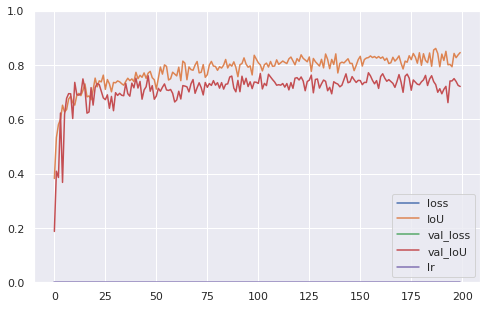

In [40]:
#plotting training values
import seaborn as sns
sns.set()

pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

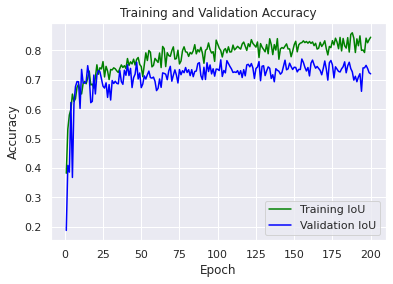

In [41]:
IoU = history1.history['IoU']
val_IoU = history1.history['val_IoU']
epochs = range(1, len(IoU) + 1)

#accuracy plot
plt.plot(epochs, IoU, color='green', label='Training IoU')
plt.plot(epochs, val_IoU, color='blue', label='Validation IoU')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

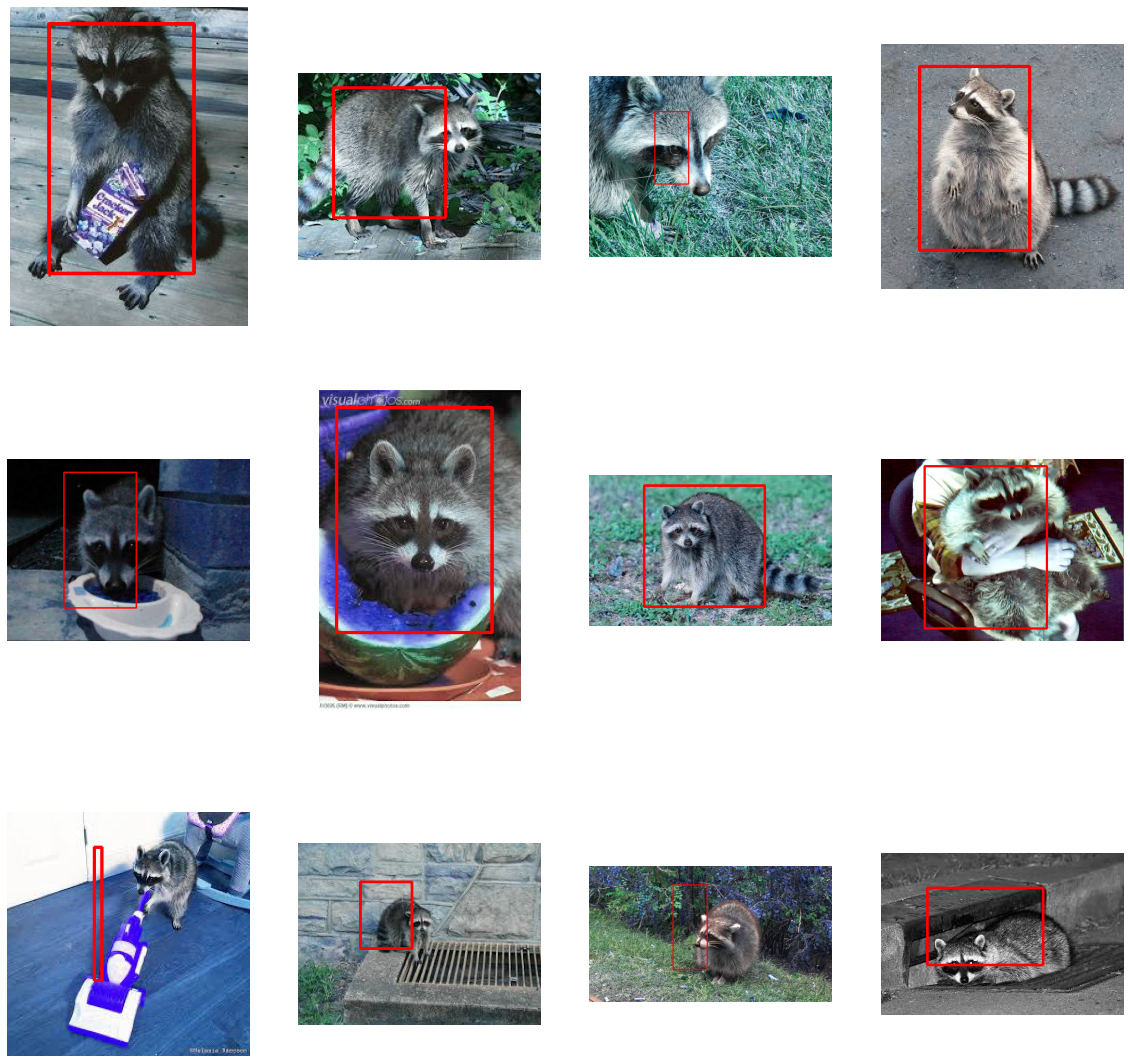

In [42]:
#showing training images with labels
df=pd.read_csv('train_labels_.csv')[161:]
plt.figure(figsize=(20,20))
for n , i in enumerate(range(12)) : 
    plt.subplot(3,4,n+1)
    
    img = cv2.imread(trainpath+str(df.iloc[i,0]))
    org_img=img.copy()
    
    image_height, image_width, _ = img.shape
    
    
    img = cv2.resize(img,(new_size,new_size))
    img = img / 255.0
    img=np.expand_dims(img,axis=0)
    region = model1.predict(img)[0]
    
    x0 = int(region[0] * image_width / new_size) 
    y0 = int(region[1] * image_height / new_size)
    x1 = int((region[2]) * image_width / new_size)
    y1 = int((region[3]) * image_height / new_size)
    
    cv2.rectangle(org_img,(x0, y0), ((x1 - x0) , (y1 - y0)) , (255,0,0),2)
    plt.imshow(org_img)   
    plt.axis('off')
    
